# Leave-one-out cross-validation

Leave-one-out cross-validation is a simple generic tool for selecting the best empirical model. When we model data empirically, for example, with a polynomial, we want to select the model which provides the best compromise between bias and variance. If the empirical model is too simple, it won't be able to describe the data properly and the result is biased. If the model is too flexible, it will start to follow statistical noise, this leads to an increased variance. This is called overfitting and leads to poor generalization of the model.

The general steps for LOO cross-validation are:

- Remove i-th datum from input data set
- Fit model to remaining data set
- Use fitted model to predict the i-th datum and store difference to original i-th datum
- Do this for all i and compute variance of the differences
- Select model with the smallest variance

The variance computed in this way is the mean-squared-error, which consists of a bias term squared and the variance. Minimizing this thus finds the best compromise between the two terms.

I demonstrate below how to select the optimal order for a polynomial model with leave-one-out (LOO) cross validation.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit 

In [19]:
rng = np.random.default_rng(seed=1)

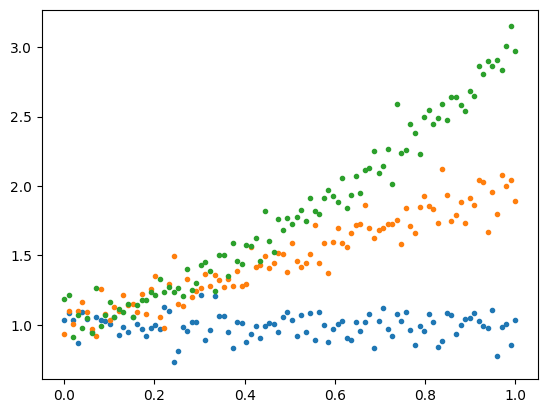

In [20]:
# create some toy data that follows polynomials of increasing degree
x = np.linspace(0, 1, 100)
y_set = np.empty((3, len(x)))
for poly_degree in (0, 1, 2):
    y_set[poly_degree] = np.polyval(np.ones(poly_degree + 1), x) + rng.normal(0, 0.1, len(x))
    
for y in y_set:
    plt.plot(x, y, ".")

In [21]:
# apply leave-one-out cross-validation
data = []
for true_poly_order, y in enumerate(y_set):

    variances = []
    tested_poly_orders = np.arange(5)
    for tested_poly_order in tested_poly_orders:
        deltas = []

        # leave out the i-th (x, y) pair in the fit
        for i in range(len(y)):
            mask = np.ones(len(y), dtype=bool)
            mask[i] = 0
            x_without_i = x[mask]
            y_without_i = y[mask]

            # least-squares cost function to fit a polynomial to the toy data
            def lsq(par):
                ym = np.polyval(par, x_without_i)
                return np.sum((y_without_i - ym) ** 2 / 0.1 ** 2)
            
            m = Minuit(lsq, np.zeros(tested_poly_order+1))
            m.strategy = 0 # faster and does not compute errors automatically
            m.migrad()
            assert m.valid

            # predict the i-th y value with the fitted model and 
            # store the delta to the real value            
            yi_predicted = np.polyval(m.values, x[i])
            deltas.append(y[i] - yi_predicted)

        variances.append(np.var(deltas))
    data.append((tested_poly_orders, variances))

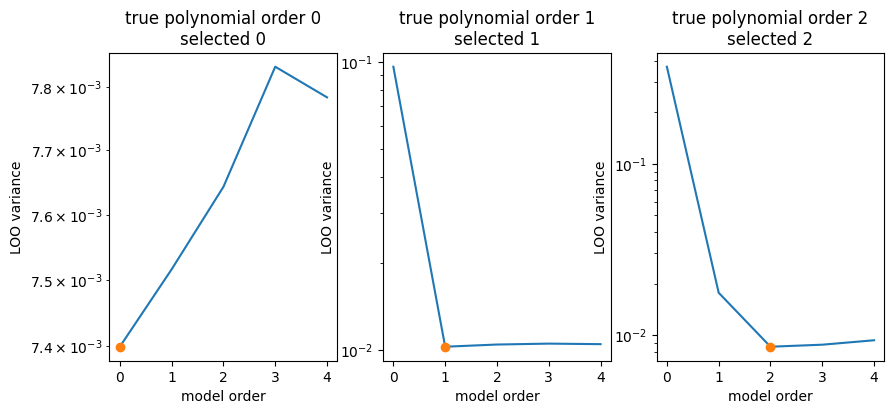

In [22]:
fig, ax = plt.subplots(1, len(data), figsize=(10, 4))
for true_poly_order, (axi, (poly_orders, variances)) in enumerate(zip(ax, data)):
    imin = np.argmin(variances)
    plt.sca(axi)
    plt.title(f"true polynomial order {true_poly_order}\nselected {imin}")
    plt.plot(poly_orders, variances)
    plt.plot(poly_orders[imin], variances[imin], marker="o")
    plt.semilogy()
    plt.ylabel("LOO variance")
    plt.xlabel("model order")